Author: Maria B. Stone

# Light-GG Tutorial 02: Fake Flight Lines (Swath Coverage)

This tutorial simulates parallel “flight lines” (e.g., aircraft passes, survey tracks)
over a rectangular area. We compute a simple **swath coverage map** on a grid:

- Define a field/grid using Light-GG
- Generate slightly wobbly flight lines
- Mark grid cells within a swath width of each line
- Visualize coverage counts and report a simple “missed area” percentage

This is an educational example, not a physical flight model.


## Setup

From the repository root, install Light-GG in editable mode:

```bash
python -m pip install -e .


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lightgg_functions import make_axes_from_reference


## 1) Define the field and grid

All units are intentionally abstract (meters, pixels, etc.).
The only assumption is that **distances are linear** and consistent.


In [2]:
# Field dimensions and grid resolution
field_width = 800.0
field_height = 500.0
cell_size = 10.0

vector_x, vector_y = make_axes_from_reference(
    x_reference=0.0,
    y_reference=0.0,
    span_x=field_width,
    span_y=field_height,
    step=cell_size,
)

# Broadcasted coordinate views (no full meshgrid needed)
X = vector_x[None, :]
Y = vector_y[:, None]

(vector_x.size, vector_y.size)


(80, 50)

## 2) Simulate flight lines

We generate several north–south lines (y from 0 to field_height),
spaced across the field in x. Each line includes a small sinusoidal “wobble”
to mimic imperfect straight driving/flying.


In [3]:
rng = np.random.default_rng(2)

swath_width = 30.0      # footprint width
line_spacing = 60.0     # spacing between nominal line centers
jitter = 8.0            # side-to-side wobble amplitude

# Nominal line x-positions (avoid edges a bit)
x_lines = np.arange(50.0, field_width - 50.0, line_spacing)

# Each line is represented as a polyline parameterized by y
n_path = 300
y_path = np.linspace(0.0, field_height, n_path)

line_paths = []
for x0 in x_lines:
    phase = rng.uniform(0, 2*np.pi)
    wobble = jitter * np.sin(2*np.pi * y_path / 200.0 + phase)
    x_path = x0 + wobble
    line_paths.append((x_path, y_path))

len(line_paths), x_lines[:5]


(12, array([ 50., 110., 170., 230., 290.]))

## 3) Compute a swath coverage map

For each grid cell at (X, Y), we estimate the closest point on the line by:
- interpolating the line’s x-position at that grid cell’s Y
- computing the cross-track distance |X - x_line(Y)|

If distance <= swath_width/2, that cell is “covered” by that pass.

We accumulate coverage counts (0 = missed, 1 = covered once, etc.).


In [4]:
coverage = np.zeros((vector_y.size, vector_x.size), dtype=int)

half_swath = swath_width / 2.0

for x_path, y_path in line_paths:
    # x position of the line evaluated at each grid row (shape: ny, 1)
    x_near = np.interp(vector_y[:, None], y_path, x_path)

    # distance from each grid cell center to the line (shape: ny, nx)
    dist = np.abs(vector_x[None, :] - x_near)

    # accumulate coverage counts
    coverage += (dist <= half_swath).astype(int)

missed = (coverage == 0)
missed_pct = 100.0 * missed.mean()

coverage.min(), coverage.max(), missed_pct


(0, 1, 55.00000000000001)

## 4) Visualize coverage

We display coverage as a heatmap (number of passes per cell)
and overlay the flight line paths.


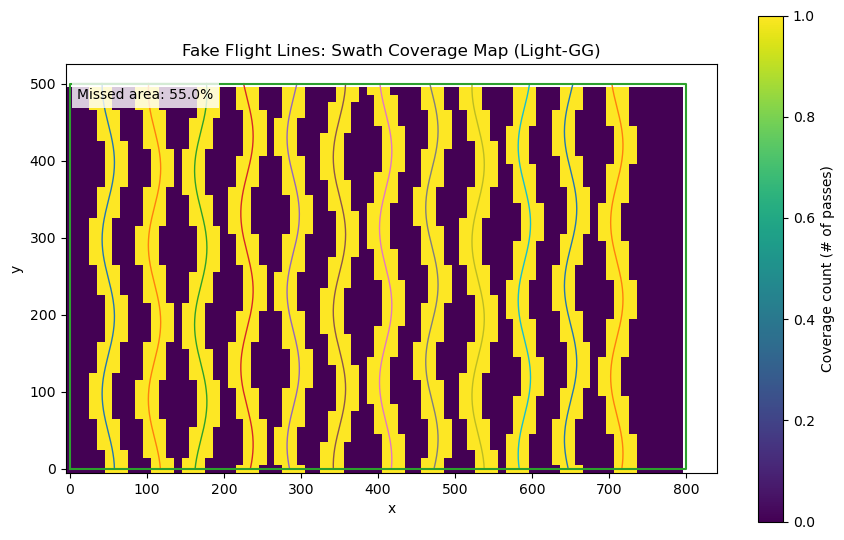

In [5]:
extent = (
    vector_x[0] - cell_size / 2,
    vector_x[-1] + cell_size / 2,
    vector_y[0] - cell_size / 2,
    vector_y[-1] + cell_size / 2,
)

plt.figure(figsize=(9, 5.5))
im = plt.imshow(
    coverage,
    origin="lower",
    extent=extent,
    aspect="equal",
)

plt.colorbar(im, label="Coverage count (# of passes)")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fake Flight Lines: Swath Coverage Map (Light-GG)")

# Overlay flight lines
for x_path, y_path in line_paths:
    plt.plot(x_path, y_path, linewidth=1)

# Field boundary
plt.plot(
    [0, field_width, field_width, 0, 0],
    [0, 0, field_height, field_height, 0],
    linewidth=1.5
)

# Annotation
plt.text(
    10, field_height - 20,
    f"Missed area: {missed_pct:.1f}%",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8, edgecolor="none")
)

plt.tight_layout()
plt.show()


## 5) Simple metrics (optional)

A few basic numbers that are easy to communicate:
- percent of missed cells
- percent of cells covered exactly once
- percent of cells covered 2+ times (overlap)


In [6]:
covered_once_pct = 100.0 * np.mean(coverage == 1)
overlap_pct = 100.0 * np.mean(coverage >= 2)

print(f"Missed area:      {missed_pct:.1f}%")
print(f"Covered once:     {covered_once_pct:.1f}%")
print(f"Covered 2+ times: {overlap_pct:.1f}%")


Missed area:      55.0%
Covered once:     45.0%
Covered 2+ times: 0.0%
